# Conclusiones de la práctica

En la siguiente ejecución hemos realizado las diferentes modificaciones que se pedían a una [una implementación del algoritmo ChaCha20](https://github.com/pts/chacha20/blob/master/chacha20_python3.py)


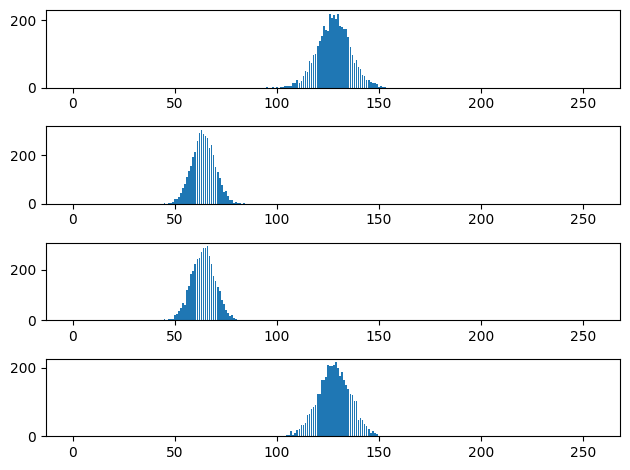

En ésta gráfica podemos ver las frecuéncias de los bits cambiados en forma de histograma para cada moficación 
pertinente, es decir la primera gráfica sin modificaciones, la segunda gráfica para la eliminación de los QUARTERROUND de las columnas y así en adelante.

Como podemos ver, una característica general de todas es que las modificaciones siguen una distribución normal, es decir, lo más común es realizar bastantes modificaciones entre los bits de origen, cosa que es positiva para encontrar mayor varianza.

También otra característica que podemos observar es que al eliminar tanto los *Diagonal Rounds* como los *Column Rounds* podemos observar una translación de la distribución hacia la izauierda con la misma forma. Eso se debe a que cada ronda hemos eliminado 4 cambios y eso hará que el número de cambios de bits totales realizados disminuya *bastante*. Podemos ver que al eliminar o las *Diagonal Rounds* o las *Column Rounds* que el número medio de modificaciones de bits varia de unos 125 a unos 60, aproximadamente un 50% menos.

En cambio entre la primera y la última hay una pequeña diferencia últimamente, ya que solamente hemos eliminado dos QUARTERROUNDS y como podemos ver no nos muestra mucha diferencia.

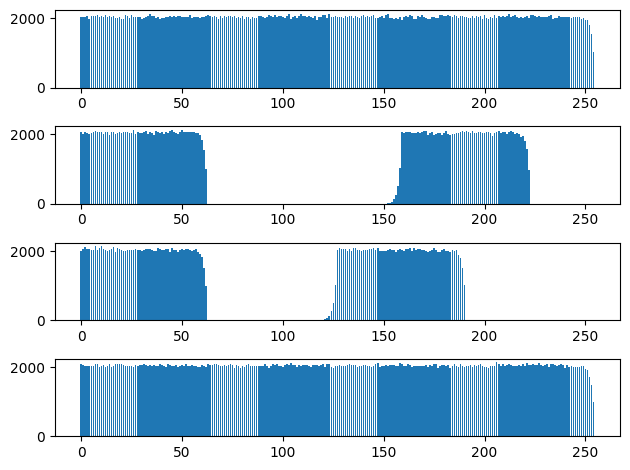

En este gráfico podemos algo parecido que en el anterior. Entre el primer y el último gráfico no hay gran diferencia por no decir ninguna. Pero en este caso, entre el segundo y el tercero que recordemos que se sonsiguen eliminando los *Column Rounds* en la segunda gráfica y eliminando los *Diagonal Rounds*, podemos ver que hay una diferencia bastante notable.

Podemos ver que en el segundo gráfico los bits de índice 60 hasta los bits de ínidice 150 no han sido modificados igual que los últimos bits tampoco.

Lo mismo pasa en la tercera gráfica pero con un intervalo más corto, en este caso, entre el bit de ínidice 60 y el bit de índice 125, pero se alarga igual con los últimos bits del índice 180 al índice 220.

En resumen, al retirar 4 QUARTERROUNDS, perdemos la misma cantidad de cambios de bit pero en una diferente forma.

La razón es que cuando hacemos las *Column Rounds* hacemos modificaciones 




# Código

## Con quarterrounds

In [36]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 4,  8, 12)
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 1, 6, 11, 12)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [37]:
!pip install bitstring

Defaulting to user installation because normal site-packages is not writeable


In [38]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)
print(original)

original = original.hex()
print(original)
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

b'\xe7\x02\xde_H\x0b\xaf\x8f\x12\x94Z\xa9\x9a^\x9aG\x05\xbb\xa6\xcc\xe2\xe5BZw0^\xae\xef\xc1\x1b\xc4'
e702de5f480baf8f12945aa99a5e9a4705bba6cce2e5425a77305eaeefc11bc4


In [39]:
exercici1 = []
exercici1.append(cambiosBits)
exercici1.append(cambiosPos)

## Sin quarterrounds 1

In [40]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 1, 6, 11, 12)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [41]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [42]:
exercici2 = []
exercici2.append(cambiosBits)
exercici2.append(cambiosPos)

## Sin quarteround 2

In [43]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 4,  8, 12)
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [44]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [45]:
exercici3 = []
exercici3.append(cambiosBits)
exercici3.append(cambiosPos)

## Sin quarteround 3

In [46]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [47]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [48]:
exercici4 = []
exercici4.append(cambiosBits)
exercici4.append(cambiosPos)

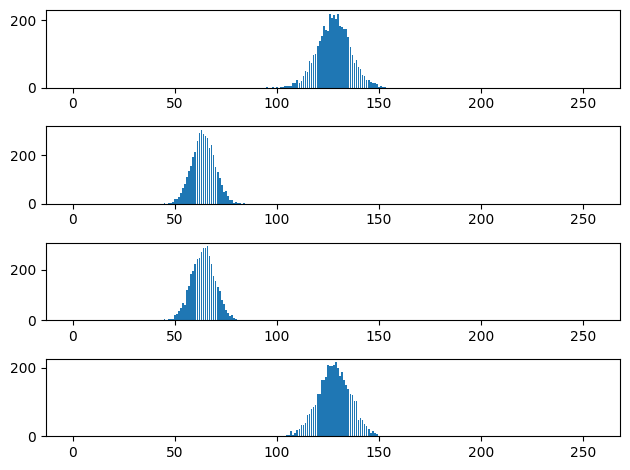

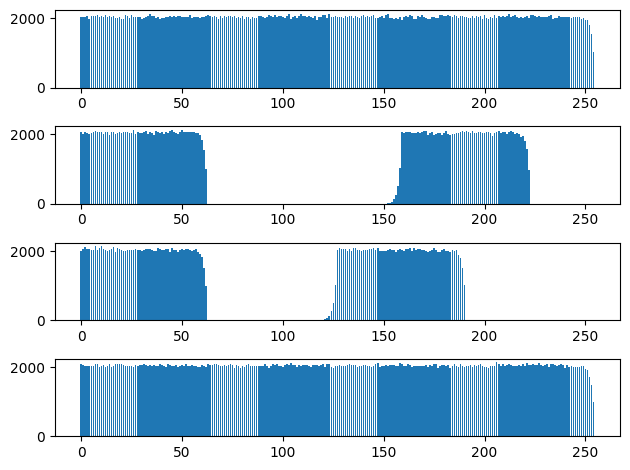

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

x = np.arange(0, 256)

y = exercici1[0]
ax1.bar(x, y)
y = exercici2[0]
ax2.bar(x, y)
y = exercici3[0]
ax3.bar(x, y)
y = exercici4[0]
ax4.bar(x, y)
fig.tight_layout()
plt.show(fig)


fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4)

x = np.arange(0, 255)
y = exercici1[1]
ax1.bar(x, y)
y = exercici2[1]
ax2.bar(x, y)
y = exercici3[1]
ax3.bar(x, y)
y = exercici4[1]
ax4.bar(x, y)
fig2.tight_layout()
plt.show(fig2)